In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat

import matplotlib.pyplot as plt

data = loadmat("./data/data.mat")["data"].T
label = loadmat("./data/label.mat")["trueLabel"].T

data.shape,label.shape

((1990, 784), (1990, 1))

In [2]:
N,D = data.shape
C = 2

In [3]:
from scipy import linalg

### custom density function

In [4]:
from scipy.stats import norm,multivariate_normal

In [5]:
def ad_pdf(X,mu_c,sigma_c,r=5):
#     print ("$\mu$",mu_c.shape)
    _,D = sigma_c.shape
    #eigen decompose sigma
    u, s, vh = np.linalg.svd(sigma_c) #eigen and svd same for symmetric square matrix
    #pick top r eigen vectors
    u_r = u[:,:r]
    s_r = s[:r]
    #calculate pdf
    det_s = s_r.prod()
    term0 = X-mu_c
    term1 = (term0 @ u_r)
    term2 = term1 @ np.diag(s_r**(-0.5))
    exp_term =  -0.5 * np.linalg.norm(term2,axis=1)**2.0
    log_pdf = ((-D/2) * np.log(2*np.pi)) + (-0.5 * np.log(det_s)) + exp_term
    assert log_pdf.shape[0]==X.shape[0], "Error in pdf"
    return (np.exp(log_pdf))

In [7]:
# plt.plot(multivariate_normal.pdf(data,mean=mu_check,cov=sigma_check,allow_singular=True))
# ad_pdf(data,mu_check,sigma_check)

In [6]:
# def ad_pdf1(x,mu_c,sigma_c,r=5):
# #     print ("$\mu$",mu_c.shape)
#     _,D = sigma_c.shape
#     #eigen decompose sigma
#     u, s, vh = np.linalg.svd(sigma_c) #eigen and svd same for symmetric square matrix
#     #pick top r eigen vectors
#     u_r = u[:,:r]
#     s_r = s[:r]
#     #calculate pdf
#     det_s = s_r.prod()
#     print (np.diag(s_r**(-0.5)).shape,u_r.shape,(x-mu_c).shape)
#     term2 = np.diag(s_r**(-0.5))@u_r.T@(x-mu_c)
#     exp_term =  -0.5 * np.linalg.norm(term2)**2.0
#     log_pdf = ((-D/2) * np.log(2*np.pi)) -(0.5*np.log(det_s)) + exp_term
# #     assert log_pdf.shape[0]==X.shape[0], "Error in pdf"
#     return (np.exp(log_pdf))

In [14]:
def e_step(X,tau,pi,mu,Sigma):
    _,C=mu.shape
    N,D = X.shape
    for c in range(C):
        mu_c = mu[:,c]
        sigma_c = Sigma[c,:,:]
        tau[:,c] = pi[c] * ad_pdf(X,mu_c,sigma_c)
#     print (tau.shape)
    log_lik = np.log(tau.sum(axis=1)).sum()
    tau = tau/tau.sum(axis=1).reshape(N,1)
    return (tau,log_lik)

def m_step(pi,tau,X,mu,Sigma):
    #update pi
    pi = tau.mean(axis=0)
    #update mu
    N,C = tau.shape
    for c in range(C):
        tau_c = tau[:,c].reshape(N,1)
#         print (tau_c.shape,X.shape,(tau_c * X).sum(axis=0).shape)
        mu[:,c] = (tau_c * X).sum(axis=0)/(tau[:,c].sum())
        X_dev = X-mu[:,c]
        Sigma[c,:,:] = (X_dev.T@np.diag(tau[:,c])@X_dev)/(tau[:,c].sum())
    return (pi,mu,Sigma)

In [10]:
#mixing proportion
pi = np.random.uniform(size=(C,1))
pi = pi/pi.sum()
pi

array([[0.60812967],
       [0.39187033]])

mu shape (784, 2)


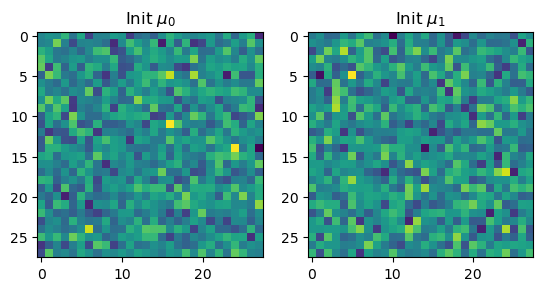

Sigma shape (2, 784, 784)


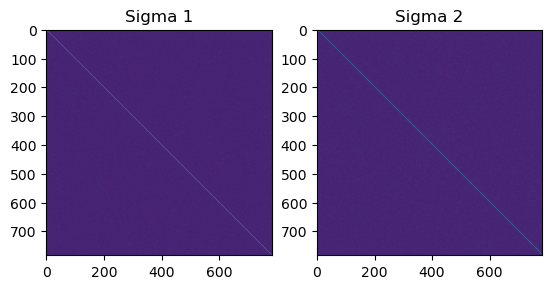

tau shape (1990, 2)


In [11]:
#init
#mu
mu = np.random.normal(size=(D,C))
print ("mu shape",mu.shape)
mu_0 = mu[:,0].reshape(28,28).T
mu_1 = mu[:,1].reshape(28,28).T
fig,axes=plt.subplots(1,2)
axes[0].imshow(mu_0)
axes[0].set_title(f"Init $\mu_0$")
axes[1].imshow(mu_1)
axes[1].set_title(f"Init $\mu_1$")
plt.show()

#Sigma
s1 = np.random.normal(scale=0.1,size=(D,D))
s2 = np.random.normal(scale=0.1,size=(D,D))
sigma1 = (s1 @ s1.T) + 2*np.identity(D)
sigma2 = (s2 @ s2.T) + 2*np.identity(D)
Sigma = np.array([sigma1,sigma2])
print ("Sigma shape",Sigma.shape)
fig,axes=plt.subplots(1,2)
axes[0].imshow(Sigma[0,:,:])
axes[0].set_title("Sigma 1")
axes[1].imshow(Sigma[1,:,:])
axes[1].set_title("Sigma 2")
plt.show()

#tau
tau = np.zeros(shape=(N,C))
print ("tau shape",tau.shape)

/Users/ashish1610dhiman/opt/anaconda3/envs/time_series_practice/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


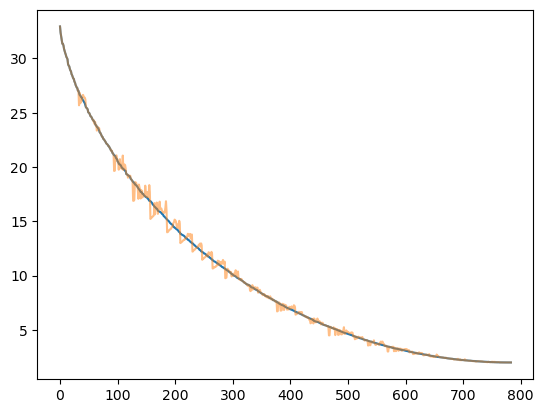

In [12]:
u, s, vh = np.linalg.svd(sigma1)
plt.plot(s)
plt.plot(linalg.eigvals(sigma1),alpha = 0.5)

  0%|          | 0/50 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Convergence of $Likelihood$')

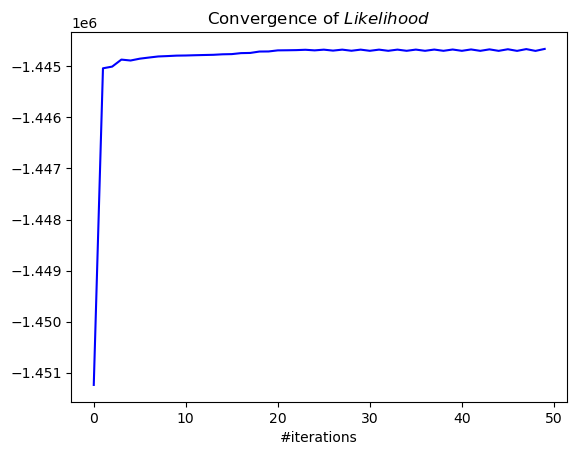

In [15]:
from tqdm.notebook import tqdm
N_iter=50

mu_list=[]
log_lik_list=[]

mu_i = mu
for cnt in tqdm(range(N_iter)):
    #do e_step
    tau,log_lik_i = e_step(data,tau,pi,mu_i,Sigma)
#     print(log_lik_i)
    log_lik_list.append(log_lik_i)
    #do m-step
    pi,mu_i,Sigma = m_step(pi,tau,data,mu_i,Sigma)
    #get log_lik
    mu_list.append(mu_i.copy())
    
plt.plot(log_lik_list,"b-")
plt.xlabel("#iterations")
plt.title("Convergence of $Likelihood$")

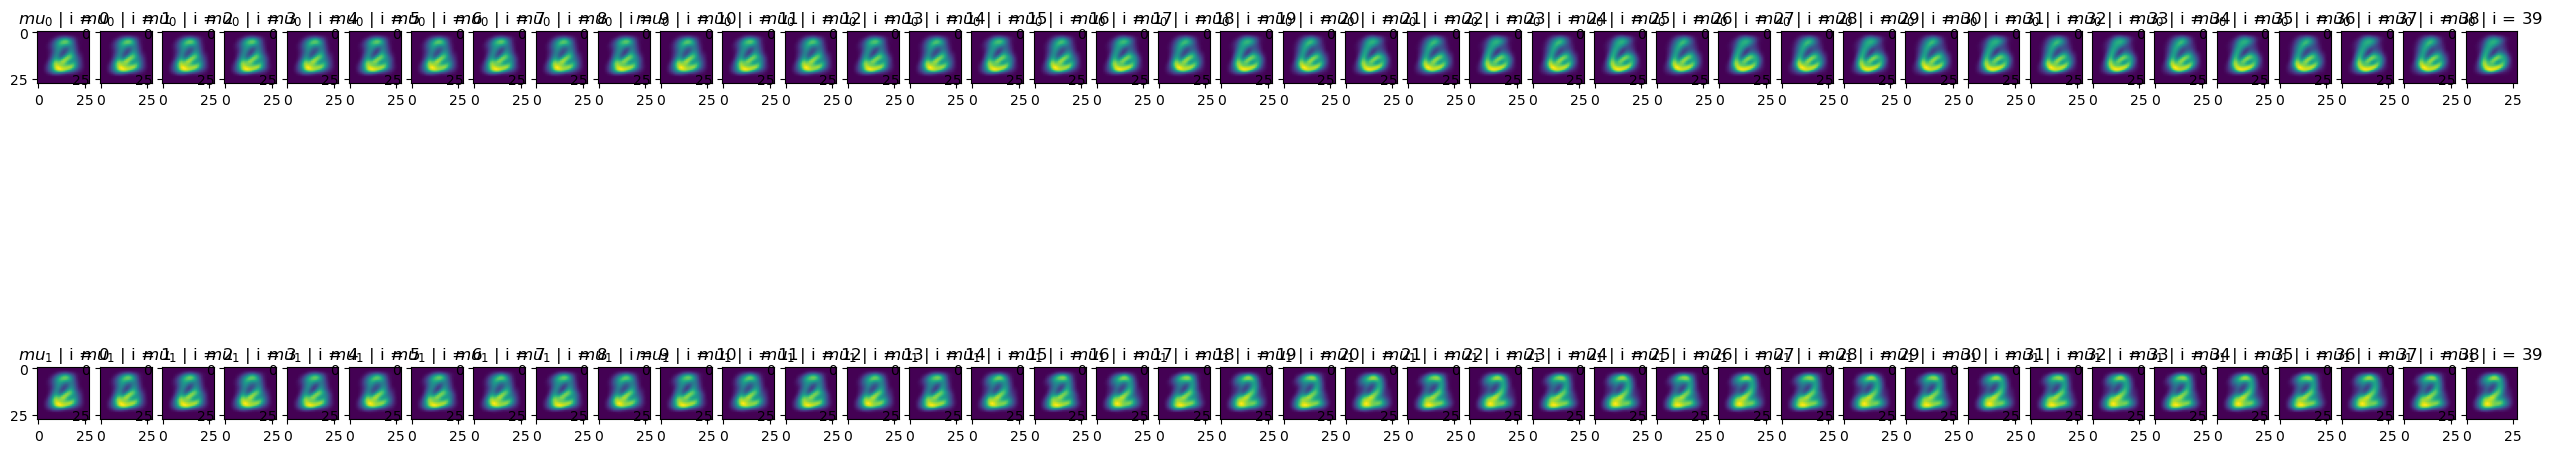

In [17]:
#plot change in mu
steps=40
fig,axes=plt.subplots(2,steps,figsize=(32,8))

for i,mu_i in enumerate(mu_list[:steps]):
    if True:
        #retrieve
        mu_0 = mu_i[:,0].reshape(28,28).T
        mu_1 = mu_i[:,1].reshape(28,28).T
        #inverse transform
        axes[0][int(i)].imshow(mu_0)
        axes[0][int(i)].set_title(f"$mu_0$ | i = {i}")
        axes[1][int(i)].imshow(mu_1)
        axes[1][int(i)].set_title(f"$mu_1$ | i = {i}")

In [18]:
max(log_lik_list)

-1444660.833340755

Final mu


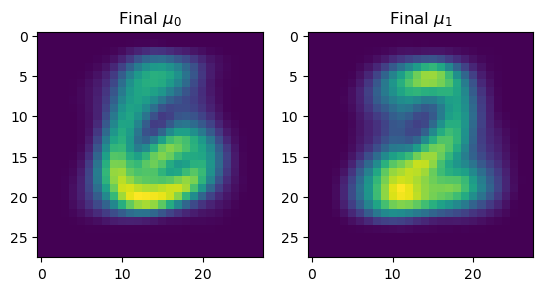

In [19]:
print ("Final mu")
mu_0 = mu_list[-1][:,0].reshape(28,28).T
mu_1 = mu_list[-1][:,1].reshape(28,28).T
fig,axes=plt.subplots(1,2)
axes[0].imshow(mu_0)
axes[0].set_title(f"Final $\mu_0$")
axes[1].imshow(mu_1)
axes[1].set_title(f"Final $\mu_1$")
plt.show()

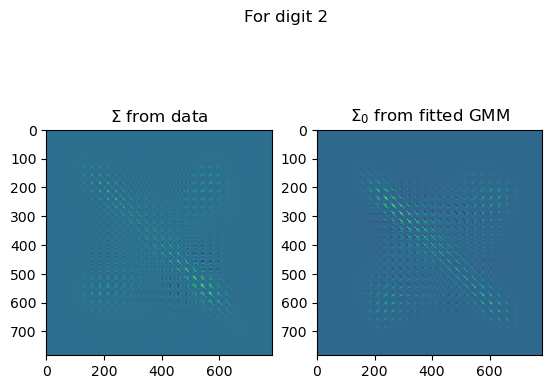

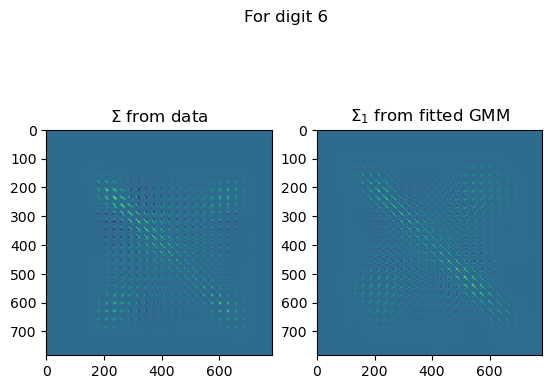

In [20]:
fig,axes=plt.subplots(1,2)
axes[0].imshow(np.cov(data[(label==2)[:,0],:].T))
axes[0].set_title(f"$\Sigma$ from data")
axes[1].imshow(Sigma[0,:,:])
axes[1].set_title(f"$\Sigma_0$ from fitted GMM")
plt.suptitle("For digit 2")
plt.show()

fig,axes=plt.subplots(1,2)
axes[0].imshow(np.cov(data[(label==6)[:,0],:].T))
axes[0].set_title(f"$\Sigma$ from data")
# axes[0].colorbar()
axes[1].imshow(Sigma[1,:,:])
# axes[1].colorbar()
axes[1].set_title(f"$\Sigma_1$ from fitted GMM")
plt.suptitle("For digit 6")
plt.show()

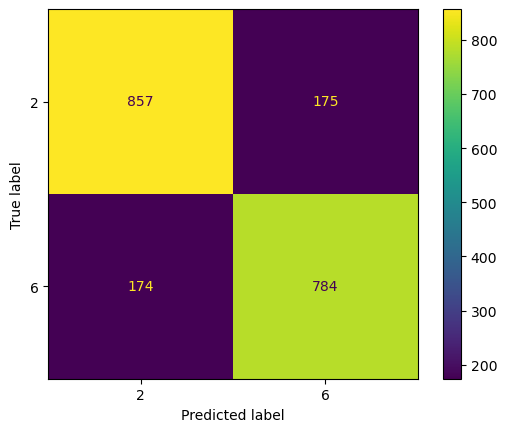

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
label_pred = np.where(np.argmax(tau,axis=1)==0,6,2)
ConfusionMatrixDisplay.from_predictions(y_true=label,y_pred=label_pred)

In [22]:
(175+174)/1990

0.17537688442211055